**1. Ambil Data**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

# Ambil data TSLA
data = yf.download("TSLA", period="max")
data = data[["Open", "High", "Low", "Close", "Volume"]]
data.head()


/tmp/ipython-input-1094022304.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TSLA", period="max")
[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500


**2. Scaling Semua Feature**

In [2]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


**3. Buat Sequence untuk GRU**

In [3]:
sequence_length = 60
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i])   # multi-feature
    y.append(scaled_data[i, 3])                  # 3 = index kolom Close

X = np.array(X)
y = np.array(y)


**4. Split Train–Test**

In [4]:
train_size = int(len(X) * 0.8)

X_train = X[:train_size]
y_train = y[:train_size]

X_test = X[train_size:]
y_test = y[train_size:]


**5. Bangun Model GRU Multi-Feature**

In [5]:
model = Sequential()
model.add(GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(GRU(64))
model.add(Dense(1))

model.compile(optimizer="adam", loss="mean_squared_error")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,657 (151.00 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

**6. Training Model**

In [6]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 2/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 7.0265e-05 - val_loss: 0.0013
Epoch 3/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 6.5018e-05 - val_loss: 0.0012
Epoch 4/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 5.7461e-05 - val_loss: 0.0011
Epoch 5/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 5.7632e-05 - val_loss: 0.0011
Epoch 6/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 5.6615e-05 - val_loss: 0.0011
Epoch 7/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 5.5723e-05 - val_loss: 8.7792e-04
Epoch 8/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 6.4909e-05 - val_loss: 8.6226e-04
Epoch 9/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 6.3696e-05 - val_loss: 0.0010
Epoch 10/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - loss: 4.6555e-05 - val_loss: 0.0014
Epoch 11/30
86/86 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 5.5057e-05 - val_loss: 0.0012
Epoch 12/3

**7. Prediksi**

In [7]:
pred_scaled = model.predict(X_test)

# Ambil scaler untuk hanya kolom Close
close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[3], scaler.scale_[3]

pred_prices = close_scaler.inverse_transform(pred_scaled)
real_prices = close_scaler.inverse_transform(y_test.reshape(-1,1))


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


**8. Plot Hasil Prediksi**

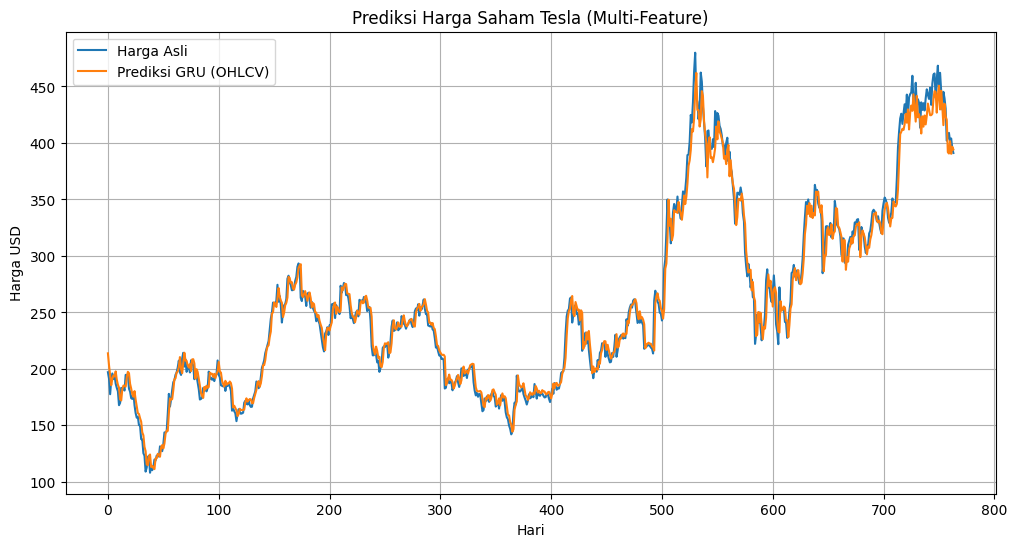

In [8]:
plt.figure(figsize=(12,6))
plt.plot(real_prices, label="Harga Asli")
plt.plot(pred_prices, label="Prediksi GRU (OHLCV)")
plt.title("Prediksi Harga Saham Tesla (Multi-Feature)")
plt.xlabel("Hari")
plt.ylabel("Harga USD")
plt.legend()
plt.grid(True)
plt.show()


**9. Evaluasi (MAE & RMSE)**

In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(real_prices, pred_prices)
rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

print("=== Evaluasi Model GRU Multi-Feature ===")
print("MAE :", mae)
print("RMSE:", rmse)


=== Evaluasi Model GRU Multi-Feature ===
MAE : 7.832376729755501
RMSE: 10.97433380780245


**10. Ringkasan Akhir dan Kesimpulan**

In [10]:
def final_summary_gru_ohlcv(real_prices, pred_prices, history, model):
    print("\n" + "="*80)
    print(" " * 20 + "FINAL SUMMARY – GRU MULTI-FEATURE (OHLCV)")
    print("="*80)

    # Dataset Info
    print("\n### DATASET INFORMATION ###")
    print(f"Total data test: {len(real_prices)} samples")
    print("Features used : ['Open', 'High', 'Low', 'Close', 'Volume']")
    print(f"Actual price range (USD) : {real_prices.min():.2f} – {real_prices.max():.2f}")

    # Training Info
    print("\n### TRAINING INFORMATION ###")
    try:
        train_loss = history.history["loss"]
        print(f"Total epochs              : {len(train_loss)}")
        print(f"Best Training Loss        : {min(train_loss):.6f}")
    except:
        print("Training loss not available")

    if "val_loss" in history.history:
        val_loss = history.history["val_loss"]
        print(f"Best Validation Loss      : {min(val_loss):.6f}")

    # Evaluasi
    mae = mean_absolute_error(real_prices, pred_prices)
    rmse = np.sqrt(mean_squared_error(real_prices, pred_prices))

    print("\n### MODEL PERFORMANCE (TEST SET) ###")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")

    print("\nInterpretasi:")
    print(f"- Rata-rata error model (MAE) sekitar ±{mae:.2f} USD.")
    print(f"- RMSE {rmse:.2f} menunjukkan model cukup stabil mengikuti pola harga.")
    print("- Error yang kecil menunjukkan bahwa GRU cukup efektif untuk prediksi jangka pendek.")

    # Model Architecture
    print("\n### MODEL ARCHITECTURE ###")
    model.summary()

    # Kesimpulan Akhir
    print("\n### FINAL CONCLUSION ###")
    print("Model GRU multi-feature berhasil mempelajari pola pergerakan harga saham Tesla.")
    print("Dengan memanfaatkan lima fitur OHLCV, model dapat memahami dinamika pasar lebih baik")
    print("dibandingkan model single-feature.")
    print("Hasil prediksi mengikuti pola tren naik dan turun dengan cukup konsisten, dengan")
    print("nilai MAE dan RMSE yang relatif rendah.")
    print("Model ini dapat dijadikan baseline dan masih dapat ditingkatkan melalui tuning atau")
    print("penambahan fitur teknikal seperti moving average atau indikator lainnya.")

    print("\n" + "="*80)
    print(" " * 28 + "PROJECT COMPLETED")
    print("="*80 + "\n")

# Panggil fungsi summary
final_summary_gru_ohlcv(real_prices, pred_prices, history, model)



                    FINAL SUMMARY – GRU MULTI-FEATURE (OHLCV)

### DATASET INFORMATION ###
Total data test: 764 samples
Features used : ['Open', 'High', 'Low', 'Close', 'Volume']
Actual price range (USD) : 108.10 – 479.86

### TRAINING INFORMATION ###
Total epochs              : 30
Best Training Loss        : 0.000035
Best Validation Loss      : 0.000597

### MODEL PERFORMANCE (TEST SET) ###
MAE  : 7.8324
RMSE : 10.9743

Interpretasi:
- Rata-rata error model (MAE) sekitar ±7.83 USD.
- RMSE 10.97 menunjukkan model cukup stabil mengikuti pola harga.
- Error yang kecil menunjukkan bahwa GRU cukup efektif untuk prediksi jangka pendek.

### MODEL ARCHITECTURE ###


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 60, 64)         │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,973 (453.02 KB)

 Trainable params: 38,657 (151.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 77,316 (302.02 KB)


### FINAL CONCLUSION ###
Model GRU multi-feature berhasil mempelajari pola pergerakan harga saham Tesla.
Dengan memanfaatkan lima fitur OHLCV, model dapat memahami dinamika pasar lebih baik
dibandingkan model single-feature.
Hasil prediksi mengikuti pola tren naik dan turun dengan cukup konsisten, dengan
nilai MAE dan RMSE yang relatif rendah.
Model ini dapat dijadikan baseline dan masih dapat ditingkatkan melalui tuning atau
penambahan fitur teknikal seperti moving average atau indikator lainnya.

                            PROJECT COMPLETED

